k-fold cross validation and logistic regression

In [24]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss,confusion_matrix

import sys
sys.path.append('../')
sys.path.append('../preprocess')

import preprocess
from preprocess.LiarLiarPreProcessor import LiarLiarPreProcessor


merge train and validation data for CV

In [25]:


def concat_train_valid_set(datafolder):
    # read the two TSV files
    df1 = pd.read_csv(os.path.join(datafolder,'train.tsv'), sep='\t')
    df2 = pd.read_csv(os.path.join(datafolder,'valid.tsv'), sep='\t')


    columns = [
            'id',                # Column 1: the ID of the statement ([ID].json).
            'label',             # Column 2: the label.
            'statement',         # Column 3: the statement.
            'subjects',          # Column 4: the subject(s).
            'speaker',           # Column 5: the speaker.
            'speaker_job_title', # Column 6: the speaker's job title.
            'state_info',        # Column 7: the state info.
            'party_affiliation', # Column 8: the party affiliation.
            
            # Column 9-13: the total credit history count, including the current statement.
            'count_1', # barely true counts.
            'count_2', # false counts.
            'count_3', # half true counts.
            'count_4', # mostly true counts.
            'count_5', # pants on fire counts.
            
            'context' # Column 14: the context (venue / location of the speech or statement).
        ]

    df1.columns = columns
    df2.columns = columns
    # merge the two dataframes on a common column
    merged_df = pd.concat([df1, df2], ignore_index=True)
    
    
    merged_df.to_csv(os.path.join(datafolder,'train_valid.tsv'),
                     sep='\t', index=False)
    
    return merged_df


In [26]:
root_folder = os.path.dirname(os.getcwd()) 
datafolder = os.path.join(root_folder,'datasets')
merged_df = concat_train_valid_set(datafolder)

Import data and use  LiarLiarPreprocessor to process raw textual data

In [27]:

liar_liar_pre_processor = LiarLiarPreProcessor(verbose=False)

#load the training data
liar_liar_pre_processor.import_training_data(
    file_name="train.tsv",
    deliminator='\t',
    custom_headers=None,
    replace_Null_NaN=True
)

#set the label column
liar_liar_pre_processor.set_label_header(
    label_header='label',
    custom_label_encoding=False,
    normalize=False,
    binarize=True
)
encoder_parameters = [
    {"encoder_name": "statement",
        "encoder_type":"bag-of-words",
        "feature_name":"statement",
        "clean_strings":True,
        "remove_stop_words":True,
        "lematize":True,
        "filtering" : {
            "filtering_enabled":False,
            "filtered_terms": []
        }
    },
    {"encoder_name": "party affiliation",
        "encoder_type":"encode",
        "feature_name":"party_affiliation",
        "encoding_mapping":None,
        "normalize":False,
        "Binarize":False,
        "filtering" : {
            "filtering_enabled":True,
            "filtered_terms": ['republican', 'democrat', 'none']
        }
    },
    {"encoder_name": "credit score",
        "encoder_type":"credit history",
        "feature_names":['count_1','count_2','count_3','count_4','count_5'],
        "compute_credit_history":True
    },
    
    {"encoder_name": "state info",
        "encoder_type":"encode",
        "feature_name":"state_info",
        "encoding_mapping":None,
        "normalize":False,
        "Binarize":False,
        "filtering" : {
            "filtering_enabled":False,
            "filtered_terms": []
        }
    },
    {"encoder_name": "speaker",
        "encoder_type":"encode",
        "feature_name":"speaker",
        "clean_strings":True,
        "remove_stop_words":True,
        "lematize":True,
        "filtering" : {
            "filtering_enabled":False,
            "filtered_terms": []
        }
    },
    {"encoder_name": "speaker_job_title",
        "encoder_type":"encode",
        "feature_name":"speaker_job_title",
        "clean_strings":True,
        "remove_stop_words":True,
        "lematize":True,
        "filtering" : {
            "filtering_enabled":False,
            "filtered_terms": []
        }
    },
    {"encoder_name": "subject",
        "encoder_type":"bag-of-words",
        "feature_name":"subjects",
        "clean_strings":True,
        "remove_stop_words":True,
        "lematize":True,
        "filtering" : {
            "filtering_enabled":False,
            "filtered_terms": []
        }
    }
]




In [28]:
#load the encoding configurations for the desired dataset
liar_liar_pre_processor.configure_encodings(encoder_parameters=encoder_parameters)
# apply encoding
y,X0,X_headers0 = liar_liar_pre_processor.get_dataset()

/home/david/Documents/sta561project/modeling_logistic/../preprocess/Encoder.py:330: RuntimeWarning: invalid value encountered in true_divide
  weighted_credit_counts = credit_counts / sums[:,None]


In [29]:

y_test,X_test0 = liar_liar_pre_processor.apply_encodings_to_new_data('test.tsv')

/home/david/Documents/sta561project/modeling_logistic/../preprocess/Encoder.py:330: RuntimeWarning: invalid value encountered in true_divide
  weighted_credit_counts = credit_counts / sums[:,None]


for each input feature condition, lasso logistic CV

In [30]:

def getXByfeatureOption(input_features, X0, X_headers0, Xtest0=None):
    metadata_col_start_idx = X_headers0.index('party affiliation')
    
    if input_features == 'statements':
        X = X0[:,:metadata_col_start_idx]
        X_headers = X_headers0[:metadata_col_start_idx]
        if Xtest0 is not None :
            Xtest = Xtest0[:,:metadata_col_start_idx]
    elif input_features == 'metadata':
        X = X0[:,metadata_col_start_idx:]
        X_headers = X_headers0[metadata_col_start_idx:]
        if Xtest0 is not None :
            Xtest = Xtest0[:,metadata_col_start_idx:]
    elif input_features == 'both':
        X =X0
        X_headers = X_headers0
        if Xtest0 is not None :
            Xtest = Xtest0
    else:
        raise ValueError(f'input features option {input_features} not implemented.' )
    if Xtest0 is not None:
        return X, X_headers,Xtest
    else:
        return X, X_headers

In [31]:

def lasso_CV (X,y,n_fold,
              Cs = np.logspace(-4, 4, 9),
              random_state = 42):
    
    # perform k-fold cross-validation for Lasso logistic regression

    kf = KFold(n_splits=n_fold,shuffle=True, random_state=random_state)
    lasso_cv_accuracy_scores = np.zeros((len(Cs),n_fold))
    lasso_cv_loss_scores = np.zeros((len(Cs),n_fold))
    for i_C,C in enumerate(tqdm(Cs)):
        cv_accuracy_scores = []
        cv_loss_scores = []
        for i_fold,(train_index,val_index)in enumerate(kf.split(X)):
            if random_state:
                fold_seed = random_state*(i_C+1)*(i_fold+1)
                lasso = LogisticRegression(penalty='l1', 
                                        C=C, 
                                        solver='saga', 
                                        random_state=fold_seed)
            else:
                lasso = LogisticRegression(penalty='l1', C=C, solver='saga')
            X_train,y_train = X[train_index],y[train_index]
            X_val,y_val = X[val_index],y[val_index]
            lasso.fit(X_train, y_train.flatten())
            y_pred = lasso.predict(X_val).flatten()
            cv_accuracy_scores.append(accuracy_score(y_val, y_pred))
            cv_loss_scores.append(log_loss(y_val, y_pred))
        lasso_cv_accuracy_scores[i_C,:] = cv_accuracy_scores
        lasso_cv_loss_scores[i_C,:] = cv_loss_scores
    return lasso_cv_accuracy_scores, lasso_cv_loss_scores


def summarize_performance(Cs,n_fold,lasso_cv_acc_scores,lasso_cv_loss_scores):
    df_cv_score = pd.DataFrame({'C': np.repeat(Cs,n_fold),
                            'accuracy':lasso_cv_acc_scores.flatten(),
                            'log_loss':lasso_cv_loss_scores.flatten()})

    df_cv_score_agg = df_cv_score.groupby('C').agg({'accuracy':[np.mean,np.std],
                                'log_loss':[np.mean,np.std]})
    df_cv_score_agg.columns = ['{}_{}'.format(col[0], col[1]) for col in df_cv_score_agg.columns]
    df_cv_score_agg = df_cv_score_agg.reset_index()
    
    
    return df_cv_score_agg


def plot_performance_df (df_cv_score_agg,input_features):
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    ax[0] = df_cv_score_agg.plot(kind='line',
                                x='C',
                                ax = ax[0],
                                y='accuracy_mean',
                                yerr ='accuracy_std',
                                label='accuracy')
    ax[0].set_xscale('log')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('l1 penalty')

    ax[1] = df_cv_score_agg.plot(kind='line',
                                x='C',
                                ax = ax[1],
                                y='log_loss_mean',
                                yerr ='log_loss_std',
                                label='log loss')
    ax[1].set_xscale('log')
    ax[1].set_ylabel('log loss')
    ax[1].set_xlabel('l1 penalty')
    
    fig.suptitle(f"""input = {input_features}, 
             max accuracy = {df_cv_score_agg['accuracy_mean'].max():.3f} with l1 penalty = {df_cv_score_agg['C'][df_cv_score_agg['accuracy_mean'].argmax()]}""")
    
    plt.close(fig)
    return fig
        

Using different input feature: statement, or metadata or both, fit logistic regression

In [32]:

performance_df_dict = {}
performance_fig_dict = {}
random_state =42
Cs = np.logspace(-4, 4, 9)
n_fold = 5

 33%|███▎      | 3/9 [00:47<01:57, 19.60s/it]/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 44%|████▍     | 4/9 [04:19<07

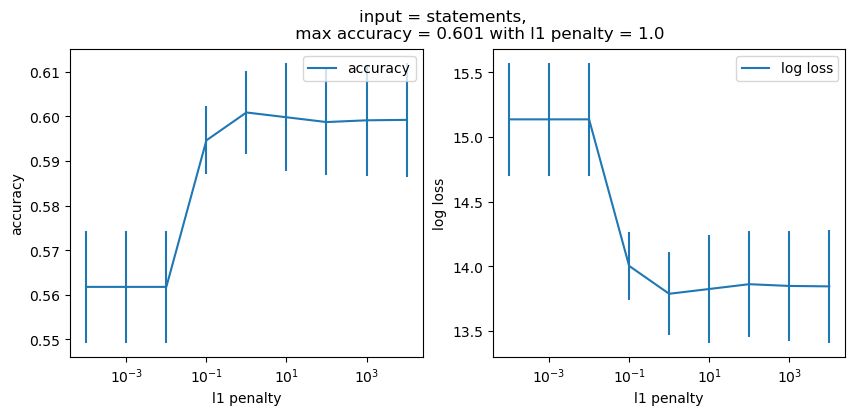

In [33]:

input_features = 'statements'
X, X_headers = getXByfeatureOption(input_features, X0, X_headers0)

lasso_cv_acc_scores, lasso_cv_loss_scores = lasso_CV(X[::],
                                                     y[::],
                                                     n_fold = n_fold,
                                                     Cs = Cs,
                                                    random_state = random_state)
df_cv_score_agg = summarize_performance(Cs,n_fold,lasso_cv_acc_scores,lasso_cv_loss_scores)
fig = plot_performance_df(df_cv_score_agg,input_features)

performance_df_dict[input_features] = df_cv_score_agg
performance_fig_dict[input_features] = fig
fig

 22%|██▏       | 2/9 [00:02<00:08,  1.26s/it]/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 3/9 [00:06<00

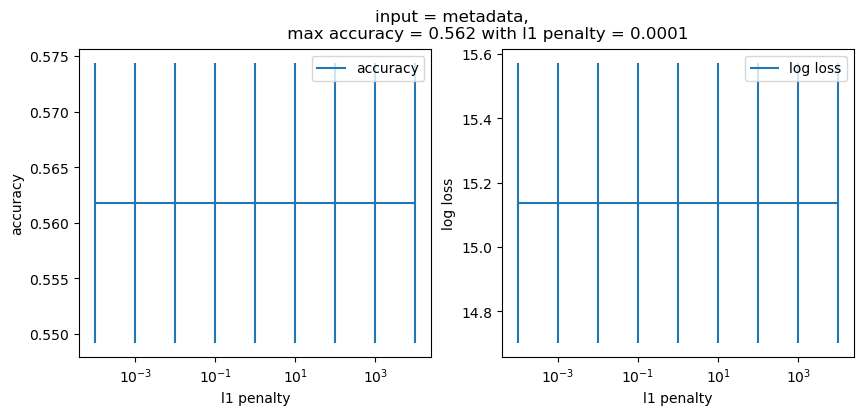

In [34]:
input_features = 'metadata'
X, X_headers = getXByfeatureOption(input_features, X0, X_headers0)

lasso_cv_acc_scores, lasso_cv_loss_scores = lasso_CV(X[::],
                                                     y[::],
                                                     n_fold = n_fold,
                                                     Cs = Cs,
                                                    random_state = random_state)
df_cv_score_agg = summarize_performance(Cs,n_fold,lasso_cv_acc_scores,lasso_cv_loss_scores)
fig = plot_performance_df(df_cv_score_agg,input_features)

performance_df_dict[input_features] = df_cv_score_agg
performance_fig_dict[input_features] = fig
fig

 22%|██▏       | 2/9 [01:52<06:48, 58.37s/it]/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 33%|███▎      | 3/9 [05:26<12

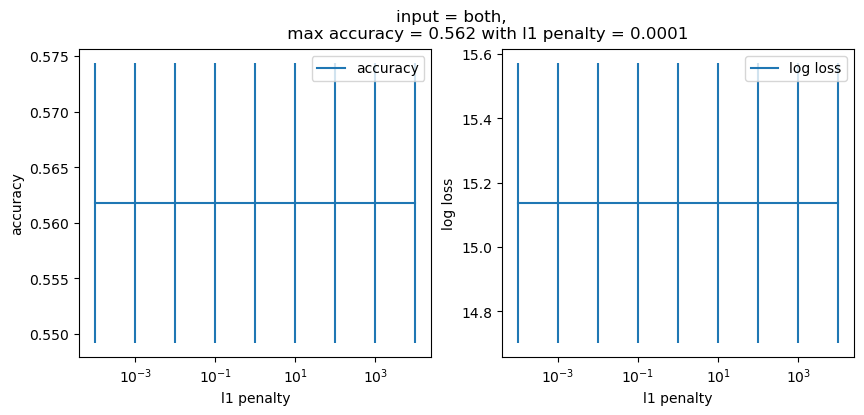

In [35]:
input_features = 'both'
X, X_headers = getXByfeatureOption(input_features, X0, X_headers0)

lasso_cv_acc_scores, lasso_cv_loss_scores = lasso_CV(X[::],
                                                     y[::],
                                                     n_fold = n_fold,
                                                     Cs = Cs,
                                                    random_state = random_state)
df_cv_score_agg = summarize_performance(Cs,n_fold,lasso_cv_acc_scores,lasso_cv_loss_scores)
fig = plot_performance_df(df_cv_score_agg,input_features)

performance_df_dict[input_features] = df_cv_score_agg
performance_fig_dict[input_features] = fig
fig

Analyze the best one, evaluate on the test set

In [36]:

y_test,X_test0 = liar_liar_pre_processor.apply_encodings_to_new_data('test.tsv')

/home/david/Documents/sta561project/modeling_logistic/../preprocess/Encoder.py:330: RuntimeWarning: invalid value encountered in true_divide
  weighted_credit_counts = credit_counts / sums[:,None]


In [37]:
input_features = 'statements'
X, X_headers,X_test = getXByfeatureOption(input_features,
                                         X0, 
                                         X_headers0,
                                         X_test0)

lasso = LogisticRegression(penalty='l1',
                           C=1,
                           solver='saga',
                           random_state=123)


In [40]:

lasso = lasso.fit(X[::50],y[::50].flatten())
y_test_pred = lasso.predict(X_test).flatten()
test_acc =accuracy_score(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
print(f'test accuracy  {test_acc}')
print(f'test confusion matrix')
print(test_confusion_matrix )

test accuracy  0.5529225908372828
test confusion matrix
[[219 334]
 [232 481]]


/home/david/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


get the features with largest absolute coeficcient

In [41]:
sort_idx = np.argsort(np.abs(lasso.coef_[0]))[::-1]
coef_sorted= lasso.coef_[0][sort_idx]
X_headers_sorted = np.array(X_headers)[sort_idx]

pos_coef_headers = X_headers_sorted[coef_sorted>0]
neg_coef_headers = X_headers_sorted[coef_sorted<0]

headers_0_coef = X_headers_sorted[coef_sorted == 0]

print('# positive coef feauters', len(pos_coef_headers))
print('# negative coef feauters', len(neg_coef_headers))
print('# 0 coef feauters', len(headers_0_coef ))


# positive coef feauters 30
# negative coef feauters 26
# 0 coef feauters 9959


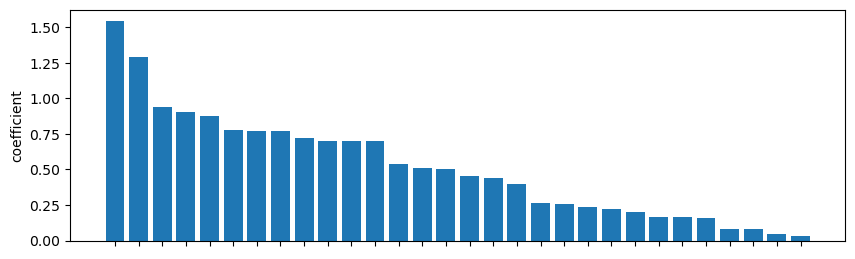

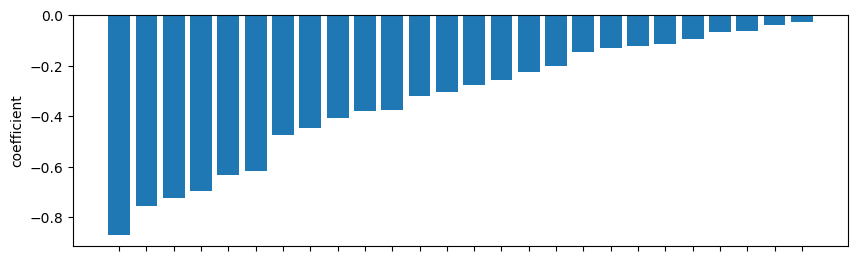

In [42]:
fig,ax  = plt.subplots(figsize=(10,3))
ax.bar(x = pos_coef_headers, 
       height = coef_sorted[coef_sorted>0] )
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('coefficient')
plt.show()


fig,ax  = plt.subplots(figsize=(10,3))
ax.bar(x = neg_coef_headers, 
       height = coef_sorted[coef_sorted<0] )
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('coefficient')
plt.show()